# Pythonで学ぶ有限要素法（平面応力編）
線形等方弾性体に対する有限要素法による二次元解析（平面応力条件）のサンプルコードです．  
YouTubeチャンネル [大学生・技術者のための有限要素法](https://www.youtube.com/@fempython) の動画に対応しています．  
このnotebookには数式と対応するPythonスクリプトしか記載していないため，詳細な解説は対応する動画をご参照ください．

## 問1'. 線形等方弾性体（平面応力条件）

**以下，支配方程式再掲**

支配方程式
$$
\int_V \boldsymbol{\sigma}\cdot \delta \boldsymbol{\varepsilon} \mathrm{d}v = \int_V \boldsymbol{b}\cdot \delta \boldsymbol{u} \mathrm{d}v + \int_S \boldsymbol{t}\cdot \delta \boldsymbol{u} \mathrm{d}s
$$
構成式
$$
\sigma^{ij} = C^{\ ijkl}\varepsilon_{kl}
$$
弾性係数
$$
C^{\ ijkl}=\lambda \delta^{ij}\delta^{kl} + \mu (\delta^{ik}\delta^{jl} + \delta^{il}\delta^{jk})
\\
\lambda = \frac{E\nu }{(1+\nu )(1-2\nu )},\quad \mu = \frac{E}{2(1+\nu )}
\\
E=205\ \mathrm{GPa},\ \nu = 0.27
$$
離散化された支配方程式
$$
\int_{V^{\mathrm{e}}} \{ \delta u \}^{\mathrm{T}}[B]^{\mathrm{T}}\{ \sigma \} \mathrm{d}v^{\mathrm{e}} = \int_{V^{\mathrm{e}}} \{ \delta u \}^{\mathrm{T}}[N]\{ b \} \mathrm{d}v^{\mathrm{e}} + \int_{S^{\mathrm{e}}} \{ \delta u \}^{\mathrm{T}}[N]\{ t \} \mathrm{d}s^{\mathrm{e}}
$$
要素剛性行列
$$
\left[ K^{\mathrm{e}}_{ij} \right] = \frac{ \partial \left\{ f^{\mathrm{e}}_{\mathrm{in}i} \right\} }{\partial \left\{ u_j\right\} } = \int_{V^{\mathrm{e}}} [B]^{\mathrm{T}} [C] [B] \mathrm{d}v^{\mathrm{e}}
$$
要素剛性方程式
$$
[K^{\mathrm{e}}]\{ u \} = \{ f^{\mathrm{e}} \}
$$
全体剛性方程式
$$
[K]\{ u \} = \{ F \}
$$

## 1. メッシュ作成

行列計算用ライブラリ（問1. 基本編 再掲）

In [ ]:
try:
    import cupy as np
    from cupyx.scipy.sparse import csr_matrix
    from cupyx.scipy.sparse.linalg import spsolve
    gpu_available = True
    print("CuPyを使用します(GPU利用可能)")
except ImportError:
    import numpy as np
    from scipy.sparse import csr_matrix
    from scipy.sparse.linalg import spsolve
    gpu_available = False
    print("NumPyを使用します(GPU利用不可)")

NumPyを使用します(GPU利用不可)


座標情報の実装（**板厚が追加される**）

In [ ]:
# メッシュのサイズ
width, height, depth = 100e-3, 20e-3, 1e-3
# 分割数
nx, ny = 10, 2  # x方向, y方向
# 節点の座標を生成
x = np.linspace(0, width, nx + 1)
y = np.linspace(0, height, ny + 1)
X, Y = np.meshgrid(x, y)
coords = np.column_stack([X.ravel(), Y.ravel()])
n_point, n_dof = coords.shape  # 全体節点数, 自由度数
f"全体節点数: {n_point}, 自由度数: {n_dof}"

'全体節点数: 33, 自由度数: 2'

コネクティビティーの実装（問1. 基本編 再掲）

In [ ]:
# 要素-全体節点番号の対応
connectivity = []
for j in range(ny):
    for i in range(nx):
       # 反時計回りに追加
        n1 = j * (nx + 1) + i
        n2 = n1 + 1
        n3 = n1 + (nx + 1) + 1
        n4 = n1 + (nx + 1)
        connectivity.append([n1, n2, n3, n4])
n_element = len(connectivity)  # 要素数
f"要素数: {n_element}"

'要素数: 20'

境界条件（固定点）の実装（問1. 基本編 再掲）

In [ ]:
# 固定点 (節点番号, 自由度番号(x: 0, y: 1))形式で格納
fix_points = [
    (0, 0),  # 節点0, x方向
    (0, 1),  # 節点0, y方向
    (11, 0),  # 節点11, x方向
    (11, 1),  # 節点11, y方向
    (22, 0),  # 節点22, x方向
    (22, 1),  # 節点22, y方向
]

境界条件（荷重）の実装（問1. 基本編 再掲）

In [ ]:
# 荷重 (節点番号, 自由度番号, 荷重)形式で格納
applied_forces = [
    (32, 1, -1000.0),  #節点32, y方向, -1000N
]

メッシュ確認（問1. 基本編 再掲）

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.collections import PolyCollection

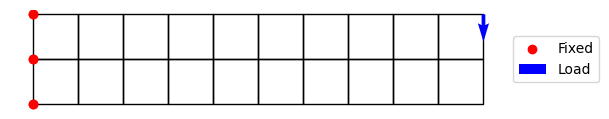

In [ ]:
_, ax = plt.subplots()

# メッシュの描画
vertices = coords[np.asarray(connectivity)]
if gpu_available:
    vertices = np.asnumpy(vertices)
collection = PolyCollection(vertices, edgecolors="black", facecolors="none")
ax.add_collection(collection)

if gpu_available:
    coords_cpu = np.asnumpy(coords)
else:
    coords_cpu = coords

# 固定点の描画
fix_pts = [ipnt for ipnt, _ in fix_points]
ax.scatter(
    coords_cpu[fix_pts, 0],
    coords_cpu[fix_pts, 1],
    color="r",
    label="Fixed",
)

# 荷重の描画
loads = np.zeros_like(coords)
load_pts = []
for ipnt, idof, force in applied_forces:
    loads[ipnt, idof] = force
    load_pts.append(ipnt)
loads /= (np.max(np.abs(loads)) / max(width / nx, height / ny))
if gpu_available:
    loads_cpu = np.asnumpy(loads)
else:
    loads_cpu = loads
ax.quiver(
    coords_cpu[load_pts, 0],
    coords_cpu[load_pts, 1],
    loads_cpu[load_pts, 0],
    loads_cpu[load_pts, 1],
    color="b",
    label="Load",
)

# プロット設定
ax.autoscale()
ax.set_aspect("equal")
ax.axis("off")
ax.legend(loc="center left", bbox_to_anchor=(1.0, 0.5))
plt.savefig("mesh_plane_stress.png", dpi=300, transparent=True)

## 2. 形状関数の実装（問1. 基本編 再掲）

自然座標系での積分点座標

In [ ]:
# 一次元での積分点座標
gauss_points_1d = np.array([-1 / np.sqrt(3), 1 / np.sqrt(3)])
# 一次元での積分点を並べて二次元上に配置する
r1, r2 = np.meshgrid(gauss_points_1d, gauss_points_1d)
# 二次元での積分点座標
gauss_points_2d = np.vstack([r1.flatten(), r2.flatten()]).T
# 各積分点での重み
weights = np.array([1.0, 1.0, 1.0, 1.0])

形状関数の取得
$$
N^1(r_1,r_2)=\frac{1}{4}(1-r_1)(1-r_2)\\
N^2(r_1,r_2)=\frac{1}{4}(1+r_1)(1-r_2)\\
N^3(r_1,r_2)=\frac{1}{4}(1+r_1)(1+r_2)\\
N^4(r_1,r_2)=\frac{1}{4}(1-r_1)(1+r_2)
$$

In [ ]:
def get_shape_func(rcods: np.ndarray) -> np.ndarray:
    """座標から対応する形状関数Nを取得する"""
    r1, r2 = rcods[..., 0], rcods[..., 1]
    N = np.array([
        0.25 * (1 - r1) * (1 - r2),  # N1
        0.25 * (1 + r1) * (1 - r2),  # N2
        0.25 * (1 + r1) * (1 + r2),  # N3
        0.25 * (1 - r1) * (1 + r2),  # N4
    ]).T
    return N

自然座標系におけるBマトリックスの取得
$$
B^1_1(r_1,r_2) = \frac{\partial N^1(r_1,r_2)}{\partial r_1}=-\frac{1}{4}(1-r_2),\quad
B^1_2(r_1,r_2) = \frac{\partial N^1(r_1,r_2)}{\partial r_2}=-\frac{1}{4}(1-r_1)\\
B^2_1(r_1,r_2) = \frac{\partial N^2(r_1,r_2)}{\partial r_1}=\frac{1}{4}(1-r_2),\quad
B^2_2(r_1,r_2) = \frac{\partial N^2(r_1,r_2)}{\partial r_2}=-\frac{1}{4}(1+r_1)\\
B^3_1(r_1,r_2) = \frac{\partial N^3(r_1,r_2)}{\partial r_1}=\frac{1}{4}(1+r_2),\quad
B^3_2(r_1,r_2) = \frac{\partial N^3(r_1,r_2)}{\partial r_2}=\frac{1}{4}(1+r_1)\\
B^4_1(r_1,r_2) = \frac{\partial N^4(r_1,r_2)}{\partial r_1}=-\frac{1}{4}(1+r_2),\quad
B^4_2(r_1,r_2) = \frac{\partial N^4(r_1,r_2)}{\partial r_2}=\frac{1}{4}(1-r_1)
$$

In [ ]:
def get_bmat_natural(rcods: np.ndarray) -> np.ndarray:
    """座標から自然座標系でのBマトリックスを返す"""
    r1, r2 = rcods[..., 0], rcods[..., 1]
    # BI1 = ∂NI/∂r1 (:, 4)
    B1 = np.array([
        -0.25 * (1 - r2),  # B11
        0.25 * (1 - r2),  # B21
        0.25 * (1 + r2),  # B31
        -0.25 * (1 + r2),  # B41
    ]).T
    # BI2 = ∂NI/∂r2 (:, 4)
    B2 = 0.25 * np.array([
        -0.25 * (1 - r1),  # B12
        -0.25 * (1 + r1),  # B22
        0.25 * (1 + r1),  # B32
        0.25 * (1 - r1),  # B42
    ]).T
    return np.stack((B1, B2), axis=-1)  # (:, 4, 2)

# 積分点座標から自然座標系でのBマトリックスを作成
bmat_nat = get_bmat_natural(gauss_points_2d)

全体座標系におけるBマトリックスと重みの取得
$$
B^I_i
= \frac{\partial N^I}{\partial x_i}
= \frac{\partial N^I}{\partial r_j}  \frac{\partial r_j}{\partial x_i}
= B^I_{\mathrm{nat}\ j}\ J_{ji}^{-1}
$$

In [ ]:
def get_bmatrix(ncods: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    """全体座標から全体座標系でのBマトリックスと重み×ヤコビ行列式を取得する"""
    # ヤコビ行列 Jij = BnatIj * xIi
    jacob = np.einsum("gIj,...Ii->...gij", bmat_nat, ncods)
    # ヤコビ行列指揮 detJ
    detJ = np.sqrt(np.linalg.det(np.einsum("...gki,...gkj->...gij", jacob, jacob)))
    # J^-1ji
    jinv = np.linalg.inv(jacob)
    # 全体座標系でのBマトリックス BIi = BnatIj * J^-1ji
    bmat_phys = np.einsum("gIj,...gji->...gIi", bmat_nat, jinv)
    # 重み×ヤコビ行列式 w * detJ
    wdetJ = weights * detJ
    # 全体座標系でのBマトリックスと重み×ヤコビ行列式を返す
    return bmat_phys, wdetJ

## 3. 支配方程式の実装

弾性係数の実装（**平面応力条件**）
$$
[C] = \begin{bmatrix} \frac{E}{1-\nu^2} & \frac{\nu E}{1-\nu^2} & 0 \\ \frac{\nu E}{1-\nu^2} & \frac{E}{1-\nu^2} & 0 \\ 0 & 0 & \frac{E}{2(1+\nu )} \end{bmatrix}
$$

In [ ]:
# 鋼材を想定
# ヤング率 E
YOUNG = 205e9
# ポアソン比 ν
POISSON = 0.27

In [ ]:
# 弾性係数行列 C (平面応力条件)
Cmatrix = np.array(
    [
        [YOUNG / (1 - POISSON**2), POISSON * YOUNG / (1 - POISSON**2), 0],
        [POISSON * YOUNG / (1 - POISSON**2), YOUNG / (1 - POISSON**2), 0],
        [0, 0, YOUNG / 2 / (1 + POISSON)],
    ]
)

全体剛性行列の初期化

In [ ]:
# 全体剛性 (全自由度数 = 次元(n_dof) * 全節点数(n_point))
Kmatrix = np.zeros((n_dof * n_point, n_dof * n_point))
Fvector = np.zeros(n_dof * n_point)
# Bマトリックスの行数 (変形に関する自由度)
n_dfdof = 3  # 二次元解析
# n_dfdof = 6  # 三次元解析
# 要素を構成する節点数(今回はすべて四角形一次)
n_node = 4
# 要素内の積分点数(今回はすべて積分次数2)
n_intgp = 4
# バッチサイズ(同時に計算する要素数)
batch_size = 7

板厚の設定
- 積分の重みに利用するため，各積分点に設定する
- 平面応力条件では板厚方向のひずみは非零となるため，増分解法により解析を行う際は板厚の更新が必要

In [ ]:
# 要素ごとの積分点数（全ての要素が同じ積分点数の場合の実装例）
n_intgps = [n_intgp] * n_element
# 累積積分点番号（全ての要素が同じ積分点数の場合の実装例）
offsets = [n_intgp * ielm for ielm in range(n_element + 1)]
# 全積分点数 (Number of Total INTegralPoints)
n_tintgp = sum(n_intgps)
# 板厚の初期値を設定（全積分点それぞれに板厚を設定）
thick = np.full(n_tintgp, depth)

要素剛性行列の計算・全体剛性行列への足し込み  
（平面応力上限の場合，$w_{I_{\mathrm{g}}} t$（面の重み*板厚）を重みとして計算する）
$$
\begin{aligned}
\left[ K^{\mathrm{e}} \right]
&= \int_{V^{\mathrm{e}}} [B]^{\mathrm{T}} [C] [B] \mathrm{d}v^{\mathrm{e}} \\
& \approx \sum_{I_{\mathrm{g}}=1}^{N_{\mathrm{g}}}[B]^{\mathrm{T}} [C] [B]w_{I_{\mathrm{g}}} t\det \boldsymbol{J} \\
&= \sum_{I_{\mathrm{g}}=1}^{N_{\mathrm{g}}}
\begin{bmatrix} \frac{\partial N^1}{\partial x_1} & 0 & \frac{\partial N^1}{\partial x_2} \\ 0 & \frac{\partial N^1}{\partial x_2} & \frac{\partial N^1}{\partial x_1} \\ \vdots & \vdots & \vdots \\ \frac{\partial N^N}{\partial x_1} & 0 & \frac{\partial N^N}{\partial x_2} \\ 0 & \frac{\partial N^N}{\partial x_2} & \frac{\partial N^N}{\partial x_1} \end{bmatrix}
\begin{bmatrix} \frac{E}{1-\nu^2} & \frac{\nu E}{1-\nu^2} & 0 \\ \frac{\nu E}{1-\nu^2} & \frac{E}{1-\nu^2} & 0 \\ 0 & 0 & \frac{E}{2(1+\nu )} \end{bmatrix}\begin{bmatrix} \frac{\partial N^1}{\partial x_1} & 0 & \cdots & \frac{\partial N^N}{\partial x_1} & 0 \\ 0 & \frac{\partial N^1}{\partial x_2} & \cdots & 0 & \frac{\partial N^N}{\partial x_2} \\ \frac{\partial N^1}{\partial x_2} & \frac{\partial N^1}{\partial x_1} & \cdots & \frac{\partial N^N}{\partial x_2} & \frac{\partial N^N}{\partial x_1} \end{bmatrix}
w_{I_{\mathrm{g}}} t\det \boldsymbol{J}
\end{aligned}
$$
最終行は平面ひずみ条件のものであることに注意

In [ ]:
# バッチサイズ分一気に計算
for idx in range(0, n_element, batch_size):
    # 同時に計算する要素番号
    batch = list(range(idx, min(idx + batch_size, n_element)))

    # Bマトリックスと重み*ヤコビアンの取得
    Bmatrix, wdetJv = get_bmatrix(coords[np.asarray(connectivity)[batch]])
    # 行列[B]の作成
    Bd = np.zeros((len(batch), n_intgp, n_dfdof, n_dof * n_node))
    Bd[..., 0, ::n_dof] = Bmatrix[..., 0]
    Bd[..., 2, ::n_dof] = Bmatrix[..., 1]
    Bd[..., 1, 1::n_dof] = Bmatrix[..., 1]
    Bd[..., 2, 1::n_dof] = Bmatrix[..., 0]

    # 各積分点の板厚 (batch_size, n_intgp)
    thick_elm = np.array([thick[offsets[ielm] : offsets[ielm + 1]] for ielm in batch])
    # 面積分の重みに板厚を掛けて体積分の重みとする
    wdetJv *= thick_elm

    # 要素剛性行列の計算
    ke = np.einsum("...gki, kl, ...glj, ...g -> ...ij", Bd, Cmatrix, Bd, wdetJv)

    # 全体剛性行列への足し込み K <- Ke
    for i, ielm in enumerate(batch):
        for inod in range(n_node):
            for jnod in range(n_node):
                for idof in range(n_dof):
                    for jdof in range(n_dof):
                        ipnt = connectivity[ielm][inod]
                        jpnt = connectivity[ielm][jnod]
                        Kmatrix[n_dof * ipnt + idof, n_dof * jpnt + jdof] += ke[
                            i, n_dof * inod + idof, n_dof * jnod + jdof
                        ]

## 4. 境界条件の適用（問1. 基本編 再掲）

境界条件（荷重）

In [ ]:
# 境界条件(荷重)
for ipnt, idof, force in applied_forces:
    # 荷重が加わる全体自由度番号
    idx = n_dof * ipnt + idof
    # 右辺外力ベクトルに荷重を加える
    Fvector[idx] += force

境界条件（固定端）

In [ ]:
# ペナルティー係数*全体剛性行列成分の最大値
penalty = 1.0e8 * np.max(np.abs(Kmatrix))
for ipnt, idof in fix_points:
    # 固定点の全体自由度番号
    idx = n_dof * ipnt + idof
    # 全体剛性行列の対角成分にペナルティーを加える
    Kmatrix[idx, idx] += penalty

## 5. 剛性方程式の求解（問1. 基本編 再掲）

全体剛性方程式$[K]\{U\}=\{F\}$を解く

In [ ]:
Kmatrix = csr_matrix(Kmatrix)
Uvector = spsolve(Kmatrix, Fvector)

解析結果のプロット

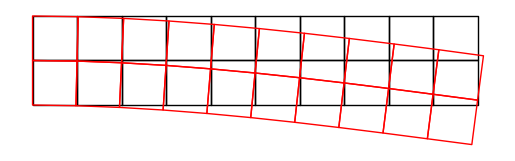

In [ ]:
# 変位
displacements = Uvector.reshape(n_point, n_dof)
# 変形後の座標
deformed_coords = coords + displacements

_, ax = plt.subplots()
# 変形前のメッシュを黒，変形後のメッシュを赤色でプロット
for cod, c in zip((coords, deformed_coords), ("black", "red")):
    vertices = cod[np.asarray(connectivity)]
    if gpu_available:
        vertices = np.asnumpy(vertices)
    collection = PolyCollection(vertices, edgecolors=c, facecolors="none")
    ax.add_collection(collection)

ax.autoscale()
ax.set_aspect("equal")
ax.axis("off")
plt.savefig("result_plane_stress.png", dpi=300, transparent=True)

## 6. 応力分布のプロット

各積分点における応力の計算式
$$
\{ \sigma \} = [C][B]\{ u \} = [C]\{ \varepsilon \} \\
\sigma_i = C_{ij} B_{jk} u_k = C_{ij}\varepsilon_{j}
$$
相当応力（ミーゼス応力）$\bar{\sigma}$の計算式
$$
\begin{align}
\bar{\sigma}
&= \sqrt{ \frac{1}{2} \left[ (\sigma_{x}-\sigma_{y})^2 + (\sigma_{y}-\sigma_{z})^2 + (\sigma_{z}-\sigma_{x})^2 + 6( \sigma_{xy}^2 + \sigma_{yz}^2 + \sigma_{zx}^2 ) \right] } \\
&= \sqrt{ \sigma_{x}^2 - \sigma_{x}\sigma_{y} + \sigma_{y}^2 + 3\sigma_{xy}^2 }
\quad (\because \sigma_{z} = \sigma_{yz} = \sigma_{zx}=0)
\end{align}
$$
（2行目は平面応力条件を適用している）


積分点における量

In [ ]:
# 相当応力（equivalent stress)
eqv_stress_gp = np.zeros(n_tintgp)
# 積分点座標（プロット用）
coords_gp = np.zeros((n_tintgp, n_dof))

節点における量

In [ ]:
# 相当応力（equivalent stress)
eqv_stress = np.zeros(n_point)
# 節点を共有する要素数のカウント用
node_counts = np.zeros(n_point)

外挿するための行列
- 積分点における量を節点に外挿する様々な方法が提案されている
- 今回は形状関数の逆行列を用いて積分点から節点へ外挿する（$\{ \bar{\sigma}{}_{\mathrm{node}} \} =[N]^{-1} \{ \bar{\sigma}{}_{\mathrm{gp}} \}$）

In [ ]:
N_gp = get_shape_func(gauss_points_2d)
N_inv = np.linalg.inv(N_gp)

相当応力の計算

In [ ]:
# バッチサイズ分一気に計算
for idx in range(0, n_element, batch_size):
    # 同時に計算する要素番号
    batch = list(range(idx, min(idx + batch_size, n_element)))
    # 要素を構成する節点番号
    elm_nodes = np.asarray(connectivity)[batch]
    # 要素の節点座標
    elm_cods = deformed_coords[elm_nodes]

    # Bマトリックスと重み*ヤコビアンの取得
    Bmatrix, _ = get_bmatrix(elm_cods)
    # 行列[B]の作成
    Bd = np.zeros((len(batch), n_intgp, n_dfdof, n_dof * n_node))
    Bd[..., 0, ::n_dof] = Bmatrix[..., 0]
    Bd[..., 2, ::n_dof] = Bmatrix[..., 1]
    Bd[..., 1, 1::n_dof] = Bmatrix[..., 1]
    Bd[..., 2, 1::n_dof] = Bmatrix[..., 0]

    # 要素を構成する節点の変位
    elm_disp = displacements[elm_nodes]
    # 行列計算のため一次元配列にする
    u_e_flat = elm_disp.reshape(len(batch), n_dof * n_node)

    # ひずみ
    strain = np.einsum("...gij, ...j -> ...gi", Bd, u_e_flat)
    # 応力
    stress = np.einsum("ij, ...gj -> ...gi", Cmatrix, strain)

    # 相当応力（ミーゼス応力）の計算（平面応力条件）
    sigma_x = stress[..., 0]
    sigma_y = stress[..., 1]
    sigma_xy = stress[..., 2]
    sigma_eqv = np.sqrt(sigma_x**2 - sigma_x * sigma_y + sigma_y**2 + 3 * sigma_xy**2)

    # 積分点における座標
    cod_gp = np.einsum("gj, ...ji->...gi", N_gp, elm_cods)

    # 積分点における相当応力と座標を保存
    for i, ielm in enumerate(batch):
        gps = range(offsets[ielm], offsets[ielm + 1])
        eqv_stress_gp[gps] = sigma_eqv[i]
        coords_gp[gps, :] = cod_gp[i]

    # 積分点から節点へ外挿
    sigma_eqv_nd = np.einsum("ij, ...j -> ...i", N_inv, sigma_eqv)

    # 節点における相当応力の足し合わせ
    for i in range(len(batch)):
        # 要素節点に対応する全体節点番号のリスト
        node_indices = elm_nodes[i]
        eqv_stress[node_indices] += sigma_eqv_nd[i]
        node_counts[node_indices] += 1

# 節点における応力の平均を取る
eqv_stress /= node_counts

相当応力のプロット（積分点）

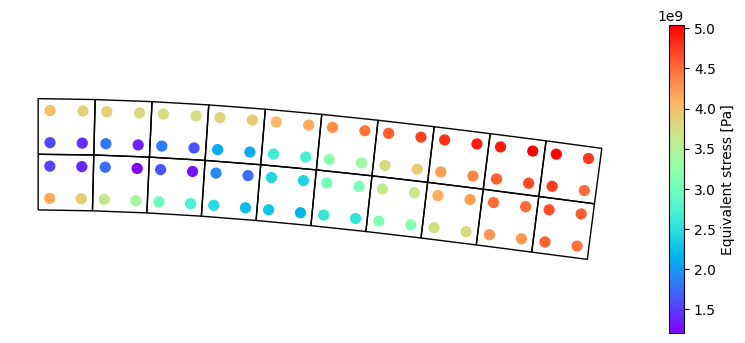

In [ ]:
# メッシュ
vertices = deformed_coords[np.asarray(connectivity)]
if gpu_available:
    vertices = np.asnumpy(vertices)
collection = PolyCollection(
    vertices, edgecolors="black", facecolors="none", linewidths=1
)

_, ax = plt.subplots(figsize=(10, 4))
ax.add_collection(collection)

# 相当応力を積分点でプロット
if gpu_available:
    coords_gp_cpu = np.asnumpy(coords_gp)
    eqv_stress_gp_cpu = np.asnumpy(eqv_stress_gp)
else:
    coords_gp_cpu = coords_gp
    eqv_stress_gp_cpu = eqv_stress_gp
sc = ax.scatter(coords_gp_cpu[:, 0], coords_gp_cpu[:, 1], c=eqv_stress_gp_cpu, cmap="rainbow", s=50)

ax.autoscale()
ax.set_aspect("equal")
ax.axis("off")
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label("Equivalent stress [Pa]")
plt.savefig("equivalent_stress_plane_stress_gp.png", dpi=300, transparent=True)

相当応力のコンタープロット

/usr/local/lib/python3.10/dist-packages/matplotlib/tri/_triangulation.py:181: RuntimeWarning: invalid value encountered in cast
  triangles = np.asarray(triangles, dtype=np.int32)


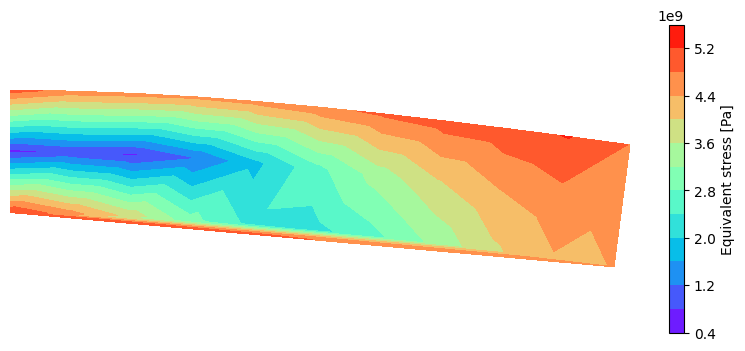

In [ ]:
_, ax = plt.subplots(figsize=(10, 4))
if gpu_available:
    deformed_coords_cpu = np.asnumpy(deformed_coords)
    eqv_stress_cpu = np.asnumpy(eqv_stress)
else:
    deformed_coords_cpu = deformed_coords
    eqv_stress_cpu = eqv_stress

contour = ax.tricontourf(
    deformed_coords_cpu[:, 0],
    deformed_coords_cpu[:, 1],
    eqv_stress_cpu,
    levels=14,
    cmap="rainbow",
)
ax.autoscale()
ax.set_aspect("equal")
ax.axis("off")
cbar = plt.colorbar(contour, ax=ax)
cbar.set_label("Equivalent stress [Pa]")
plt.savefig("equivalent_stress_plane_stress_node.png", dpi=300, transparent=True)

以上